## how often to genes in clusters share funciton?

inspired by https://www.nature.com/articles/s41467-021-25129-x, "The molecular basis, genetic control and pleiotropic effects of local gene co-expression", espeically figure 3 and go term enrishment analysis and https://www.nature.com/articles/s42003-022-03831-w "Shared regulation and functional relevance of local gene co-expression revealed by single cell analysis" go term enrichment analysis

* distance in groups vs not X
* paralog frequency
* bidirecitonal promotors X
* shared enhancers
* shared go term
* same pathway
* same complex 
* inverted/total ctcf motifs between
* hi-c contacts

I want to make some plots here, and also add all of these annotations to the cluster file. At a later point, perhaps automate the annotation of the clusters file with this information

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/new_clusters/proteincoding_rewrite.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_id = 'Cells_Cultured_fibroblasts'

protien_coding_only = True

## load in data
cluster df, expression df, gencode

In [3]:
# load in cluster data for a single tissue
cluster_df = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_all_chr.csv', index_col=0)

# load in cluster data for all tissues
all_tissue_cluster_dfs={}
for tissue_id in tissue_ids: 
    all_tissue_cluster_dfs[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_all_chr.csv', index_col=0)

In [5]:
# load in expression data (so we only compare to pairs of genes also expressed in this tissue)
# load in gene expression data
expression_df = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')

# load in expression data for all tissues 
all_tissue_expression_dfs={}
for tissue_id in tissue_ids: 
    all_tissue_expression_dfs[tissue_id] = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')


In [7]:
# load in gene data
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]
full_gencode['gene_type'] = full_gencode['info'].str.split(';').str[2].str.split('\"').str[-2]


# add in the start and end info
full_gencode['tss_start'] = np.where(full_gencode['strand'] == '+', full_gencode['start'], full_gencode['end'])
full_gencode['gene_end'] = np.where(full_gencode['strand'] == '-', full_gencode['start'], full_gencode['end'])

# filter to protien coding
if protien_coding_only:
    full_gencode = full_gencode[full_gencode['gene_type'] == 'protein_coding']

gid_gencode = full_gencode.set_index('transcript_id').drop_duplicates()

# subset to ones expressed (commenting this as im moving to analyzing clusters in all tissues)
#expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]

# index based on gene id
#expressed_gencode = expressed_gencode.set_index('transcript_id').drop_duplicates().sort_values(['chr', 'start', 'end'])

## Cluster Sizes
pairs on genes in clusters vs random pairs
and for larger groups vs other random larger groups

In [8]:
# add cluster size from gene-gene into cluster df
def get_cluster_size(row):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    return  cluster_gencode['end'].max() - cluster_gencode['start'].min()

# get sizes for null clusters
def get_null_cluster_sizes(gencode_df, num_genes, cluster_start_ids):
    # sort
    gencode_df = gencode_df.sort_values(['chr', 'start', 'end'])
    # on a per chorm basis
    size_output = []
    for chr_id in range (1,23,1):
        chr_subset_gencode = gencode_df[gencode_df['chr'] == f'chr{chr_id}']
        chr_sizes = chr_subset_gencode['end'].shift(-(num_genes-1)) - chr_subset_gencode['start']
        chr_sizes = chr_sizes.iloc[:-(num_genes-1)]
        # select only those not in this cluster
        chr_sizes = chr_sizes[~pd.Series(chr_sizes.index.values).isin(cluster_start_ids[num_genes:]).values]
        size_output.append(chr_sizes.values)
    return np.concatenate(size_output)


In [11]:
# function to get and cluster size info and get a null distribution for a given tissue 

def get_cluster_sizes_and_null(cluster_df, expression_df):
    # add cluster size to the cluster df
    cluster_df['cluster_size'] = cluster_df.apply(get_cluster_size, axis=1)

    # a list of restricted cluster starts, these are excluded from the null
    # first for n=2, first and second for n=3, ...
    cluster_start_ids = []
    for i in range(cluster_df['N_genes'].max()):
        out_ids = cluster_df[cluster_df['N_genes'] == i]['Transcripts'].str.split(',').str[:i-1].values
        if len(out_ids)>0:
            cluster_start_ids.append(np.concatenate(out_ids))
        else:
            cluster_start_ids.append([])

    # get background distances for clusters
    # subset to ones expressed in this tissue
    expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]
    # index based on gene id
    expressed_gencode = expressed_gencode.set_index('transcript_id').drop_duplicates().sort_values(['chr', 'start', 'end'])
    # should only include clusters that aren't pairs
    # can do this be removing the first transcript from the output
    pair_background = get_null_cluster_sizes(expressed_gencode, 2, cluster_start_ids)
    three_background = get_null_cluster_sizes(expressed_gencode, 3, cluster_start_ids)
    four_background = get_null_cluster_sizes(expressed_gencode, 4, cluster_start_ids)

    # combine into one df
    null_df = pd.DataFrame({'data_type':np.concatenate([['2_null']*len(pair_background), 
                                                        ['3_null']*len(three_background), 
                                                        ['4_null']*len(four_background)]), 
                'cluster_size': np.concatenate([pair_background, 
                                                three_background, 
                                                four_background])})

    # add a label column to the cluster df 
    cluster_df['data_type'] = cluster_df['N_genes'].clip(0,4).astype(str) + '_cluster'

    return cluster_df, null_df

In [12]:
# get the size distribution and tissue specific null for each tissue
cluster_size_dfs = []
null_size_dfs = []
for tissue_id in tissue_ids: 
    cluster_size_df, null_size_df = get_cluster_sizes_and_null(all_tissue_cluster_dfs[tissue_id], all_tissue_expression_dfs[tissue_id])
    cluster_size_dfs.append(cluster_size_df)
    null_size_dfs.append(null_size_df)

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/algorithms.py:531: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return f(comps_array, values)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/algorithms.py:531: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return f(comps_array, values)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/algorithms.py:531: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return f(comps_array, values)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/algorithms.py:531: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise compari

In [13]:
# combine the clusters and null
size_plot_df = pd.concat([pd.concat(cluster_size_dfs), pd.concat(null_size_dfs)])

/local/scratch/klawren/slrmtmp.43096443/ipykernel_41412/1294154052.py:3: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.kdeplot(size_plot_df, x='cluster_size', hue='data_type', clip=(0, 10**6),


Text(0.5, 1.0, 'Distribution of gene-gene distance for clusters and genomic background by number genes')

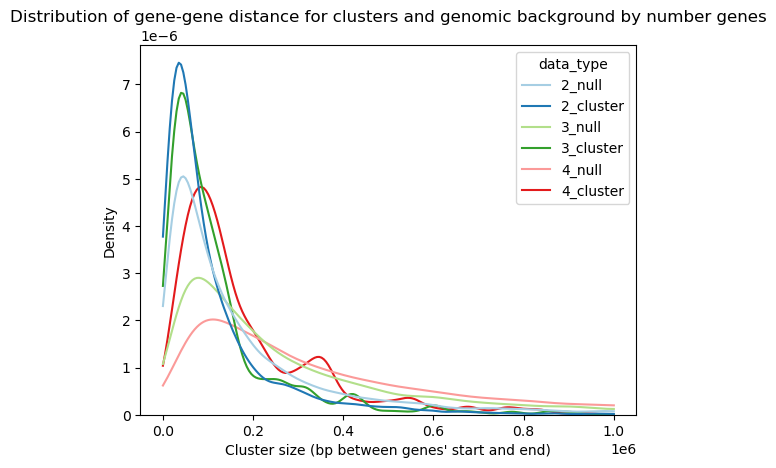

In [34]:
fig, ax = plt.subplots()

sns.kdeplot(size_plot_df, x='cluster_size', hue='data_type', clip=(0, 10**6), 
            bw_adjust=.5, fill=False, ax=ax, common_norm=False, palette = sns.color_palette("Paired"), 
            hue_order=['2_null','2_cluster','3_null','3_cluster','4_null', '4_cluster'])
plt.xlabel("Cluster size (bp between genes' start and end)")
plt.title('Distribution of gene-gene distance for clusters and genomic background by number genes')

In [39]:

# subsample size_plot_df to match number of nulls to number of clusters of each size
subsampled_null=[]
for i in range(2,5,1):
    num_samples = sum(size_plot_df['data_type'] == f'{i}_cluster') *10
    subsampled_null.append(size_plot_df[size_plot_df['data_type'] == f'{i}_null'].sample(num_samples))

# combine into one df
sub_null_size_plot_df = pd.concat([pd.concat(cluster_size_dfs), pd.concat(subsampled_null)])
# add label column
sub_null_size_plot_df['is_cluster'] = sub_null_size_plot_df['data_type'].str.contains('cluster')


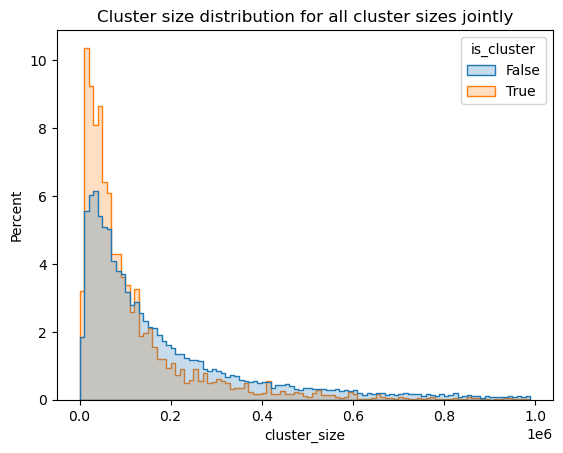

In [40]:
sns.histplot(sub_null_size_plot_df, x='cluster_size', hue='is_cluster', bins=np.arange(0, 10**6,10**4), 
             common_norm=False, stat='percent', element='step')

plt.title('Cluster size distribution for all cluster sizes jointly')
plt.show()

## bidirectional promotors
if two of the genes in the cluster are opposite strand with tss < 1000 bp away, classify as bidirecitonal promotor

In [41]:
# add cluster size from gene-gene into cluster df
# this doesn't depend on an expression filtered gencode
def get_bidirectional(row):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    # check all pairwise combos of genes
    for idx, first_gene_row in cluster_gencode.iterrows():
        for idx, second_gene_row in cluster_gencode.iterrows():
            opp_strand = first_gene_row['strand'] != second_gene_row['strand']
            close = abs(first_gene_row['tss_start'] - second_gene_row['tss_start']) <= 1000
            if opp_strand & close:
                # found a bidirectional promotor
                return True
    # didn't find a bidirectional promotor
    return False

In [43]:
# create one df with all tissues clusters
all_tissue_cluster_df = pd.concat(all_tissue_cluster_dfs, keys=tissue_ids)
# get bidirectional info for the clusters
all_tissue_cluster_df['bi_promotor'] = all_tissue_cluster_df.progress_apply(get_bidirectional, axis=1)

In [49]:
# get genome-wide null counts for each tissues expressed genes
all_tissues_bidirectional_nulls = []

for tissue_id in tissue_ids:
    expression_df = all_tissue_expression_dfs[tissue_id]
    # subset to ones expressed (commenting this as im moving to analyzing clusters in all tissues)
    expressed_gencode = full_gencode[full_gencode['transcript_id'].isin(expression_df['gene_id'])]
    # index based on gene id
    expressed_gencode = expressed_gencode.set_index('transcript_id').drop_duplicates().sort_values(['chr', 'start', 'end'])

    bidirectional_nulls={2:[], 3:[], 4:[]}

    gencode_df = expressed_gencode.sort_values(['chr', 'start', 'end'])
    for chr_id in range (1,23,1):
        chr_subset_gencode = gencode_df[gencode_df['chr'] == f'chr{21}']

        # the two conditions that must be met
        opp_strand = chr_subset_gencode['strand'] != chr_subset_gencode['strand'].shift(-1)
        close = abs(chr_subset_gencode['tss_start'] - chr_subset_gencode['tss_start'].shift(-1)) <= 1000

        # combine and extend conditions for larger clusters
        bidirectional_nulls[2] = np.concatenate([bidirectional_nulls[2], opp_strand & close])
        
    bidirectional_nulls[2] = pd.Series(bidirectional_nulls[2], dtype=bool)
    bidirectional_nulls[3] = bidirectional_nulls[2] | bidirectional_nulls[2].shift(-1)
    bidirectional_nulls[4] = bidirectional_nulls[2] | bidirectional_nulls[2].shift(-1) | bidirectional_nulls[2].shift(-2)

    all_tissues_bidirectional_nulls.append(pd.DataFrame(bidirectional_nulls))

all_tissues_bidirectional_nulls = pd.concat(all_tissues_bidirectional_nulls)


In [51]:
# get the relative fractions of bidirectional promotors or not
all_tissue_cluster_df['N_genes_clip'] = all_tissue_cluster_df['N_genes'].clip(1,4)

frac_df = {}
frac_df_noise={}
for num_genes in range(2,5):
    sub_cluster = all_tissue_cluster_df[all_tissue_cluster_df['N_genes_clip']==num_genes]
    frac_df[f'cluster_{num_genes}'] = sum(sub_cluster['bi_promotor']/len(sub_cluster))
    frac_df_noise[f'cluster_{num_genes}'] = np.sqrt(len(sub_cluster))/len(sub_cluster)

    frac_df[f'null_{num_genes}'] = sum(all_tissues_bidirectional_nulls[num_genes])/len(all_tissues_bidirectional_nulls[num_genes])
    # assume enough samples for no noise in null
    frac_df_noise[f'null_{num_genes}'] = 0

frac_bi_df = pd.DataFrame({'fraction':frac_df, 'noise':frac_df_noise})
frac_bi_df['num_genes'] = [2,2,3,3,4,4]
frac_bi_df['null_ind'] = [False,True]*3

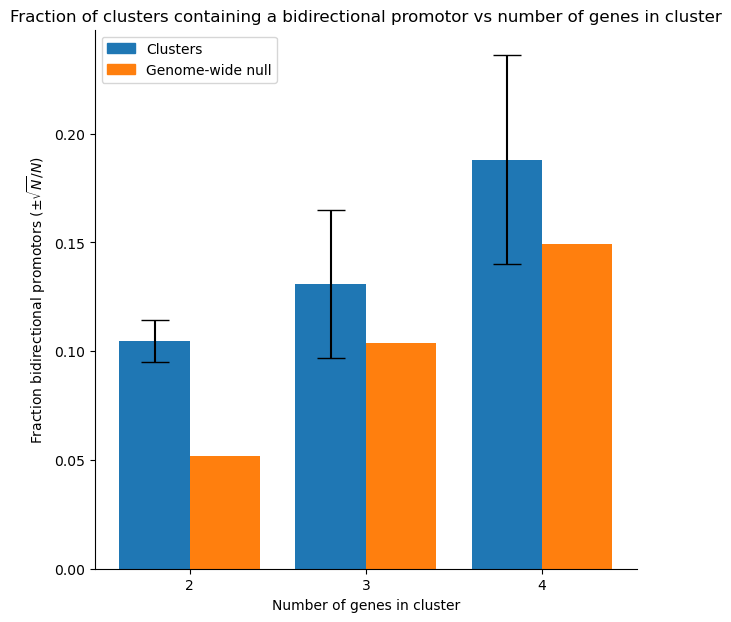

In [52]:
# plot fractions of bidirectional promotors
fig, ax = plt.subplots(figsize=(7,7))

width=.4

# for the clusters
sub_frac_df = frac_bi_df[(frac_bi_df['null_ind']==False)]
ax.bar(height=sub_frac_df['fraction'], x=sub_frac_df['num_genes'], width=width, color=sns.color_palette()[0])
ax.errorbar(y=sub_frac_df['fraction'], x=sub_frac_df['num_genes'], yerr=sub_frac_df['noise'],  ls='none', color='k', capsize=10)

# for the null
sub_frac_df = frac_bi_df[(frac_bi_df['null_ind']==True)]
ax.bar(height=sub_frac_df['fraction'], x=sub_frac_df['num_genes']+width, width=width, color=sns.color_palette()[1])

# axis and labels
ax.set_xticks(sub_frac_df['num_genes'] + width / 2, ('2', '3', '4'))
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel('Number of genes in cluster')
ax.set_ylabel('Fraction bidirectional promotors ($\pm \sqrt{N}/N$)')
ax.set_title('Fraction of clusters containing a bidirectional promotor vs number of genes in cluster')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend
cluster_patch = mpatches.Patch(color=sns.color_palette()[0], label='Clusters')
null_patch = mpatches.Patch(color=sns.color_palette()[1], label='Genome-wide null')
plt.legend(handles=[cluster_patch, null_patch])

## paralog frequency
how often are both genes paralogs/a nearby gene duplication?
is this something I can tell wtih go terms?

## Enhancer sharing 
* Supp data 4 from "Shared regulation and functional relevance of local gene co-expression revealed by single cell analysis" (https://www.nature.com/articles/s42003-022-03831-w#data-availability) correlated atac and rna-seq acessibility for epi map regions in LCLs, showed high concordence with ABC and epi map? (this could only work for lcl type cells, which I don't really have)

* ABC for 131 biosmaples (could probably find matches for most of mine)
